In [1]:

import matplotlib.pyplot as plt  # Import library for direct plotting functions
import numpy as np  # Import Numerical Python
from IPython.display import display, HTML  # Import HTML for formatting output
from scipy.integrate import ode  # Import ODE solver
from scipy.integrate import solve_ivp
import time
from numba import jit

In [2]:
def three_level_OBEs(t,y,gamma2,Omega2,gamma1,Omega1,b1,b2,delta1,delta2):
    # Write down the three level optical bloch equations
    # gamma1/2 decay rate
    # Omega1/2 rabi frequency
    # b1/2 branching ratio
    # delta1/2 detuning
    # under the rotating wave approximation, so results independent of omega

    [rho_gg, rho_ii, rho_ee, rho_gi, rho_ig, 
     rho_ge, rho_eg, rho_ie, rho_ei] = y
    # Population equations
    drho_eedt = -gamma2*rho_ee +1j/2*Omega2*(rho_ei-rho_ie)
    drho_iidt = -gamma1*rho_ii +b2*gamma2*rho_ee-1j/2*Omega2*(rho_ei-rho_ie)+1j/2*Omega1*(rho_ig-rho_gi)
    drho_ggdt = b1*gamma1*rho_ii-1j/2*Omega1*(rho_ig-rho_gi)

    # Coherence equations
    drho_eidt = (-(gamma1+gamma2)/2+1j*delta2)*rho_ei+1j/2*Omega2*(rho_ee-rho_ii)+1j/2*Omega1*rho_eg
    drho_egdt = (-gamma2/2 + 1j*(delta1+delta2))*rho_eg+1j/2*Omega1*rho_ei-1j/2*Omega2*rho_ig
    drho_igdt = (-gamma1/2 + 1j*delta1)*rho_ig+1j/2*Omega1*(rho_ii-rho_gg)-1j/2*Omega2*rho_eg

    # Complex conjugates
    drho_gedt = np.conj(drho_egdt)
    drho_gidt = np.conj(drho_igdt)
    drho_iedt = np.conj(drho_eidt)
 

    dydt = [drho_ggdt, drho_iidt, drho_eedt, drho_gidt, drho_igdt, drho_gedt, drho_egdt, drho_iedt, drho_eidt]

    return dydt

In [4]:
# Parameters
gamma1 = 0
gamma2 = 0.0001
b1 = 1
b2 = 0.01
Omega1 = 1
Omega2 = 1
delta1 = 40
delta = (np.abs(Omega2)**2-np.abs(Omega1)**2)/(4*(delta1))
delta2 = delta - delta1

## ODE method

In [5]:

# ODE method
time_start = time.time()
# Solve the optical bloch equations
# Initial conditions
y0 = [1, 0, 0, 0, 0, 0, 0, 0, 0]
# Time grid
t = np.linspace(0, 200, 1000)
# Solve the ODEs
r=ode(three_level_OBEs).set_integrator('zvode')
r.set_initial_value(y0).set_f_params(gamma2,Omega2,gamma1,Omega1,b1,b2,delta1,delta2)
# Store the value
rhos = [rho_gg, rho_ii, rho_ee, rho_gi, 
    rho_ig, rho_ge, rho_eg, rho_ie, rho_ei] = [np.zeros(len(t), dtype=complex) for i in range(9)]
index = 0
for rho in rhos:
    rho[0] = y0[index]
    index += 1

#Integration
for i in range(1, len(t)):
    r.integrate(t[i])
    index = 0
    for rho in rhos:
        rho[i] = r.y[index]
        index += 1

time_end = time.time() # End timing

print(max(rho_ee))
np.savez('testode.npz', t, rho_gg, rho_ee, rho_ii,
            t = t, rho_gg = rho_gg, rho_ee = rho_ee, rho_ii = rho_ii)
print('time cost',time_end-time_start,'s')


(0.8913629284238251+0j)
time cost 0.6455445289611816 s


## Solve_ivp method

In [12]:
#Solve_ivp method
time_start = time.time()
# Solve the optical bloch equations
# Initial conditions
y0 = [1+0j, 0, 0, 0, 0, 0, 0, 0, 0]
# Time grid
time_span = (0, 200)
# Solve the ODEs
r = solve_ivp(three_level_OBEs, time_span, y0, method = 'RK45', 
                        args = (gamma2,Omega2,gamma1,Omega1,b1,b2,delta1,delta2))

rhos = r.y
t = r.t
[rho_gg, rho_ii, rho_ee, rho_gi, 
    rho_ig, rho_ge, rho_eg, rho_ie, rho_ei] = rhos
time_end = time.time()
 # End timing
print(max(rho_ee))
np.savez('testsol.npz', time_span, t, rho_gg, rho_ee, rho_ii,
            time_span = time_span, t = t, rho_gg = rho_gg, rho_ee = rho_ee, rho_ii = rho_ii)


print('time cost',time_end-time_start,'s')

(0.9001335087459332+0j)
time cost 0.6926298141479492 s


In [13]:
t = np.load('testsol.npz')['t']
rho_ee = np.load('testsol.npz')['rho_ee']
rho_ii = np.load('testsol.npz')['rho_ii']
rho_gg = np.load('testsol.npz')['rho_gg']
print('rho_ee_max = '+ str(max(rho_ee)))

rho_ee_max = (0.9001335087459332+0j)


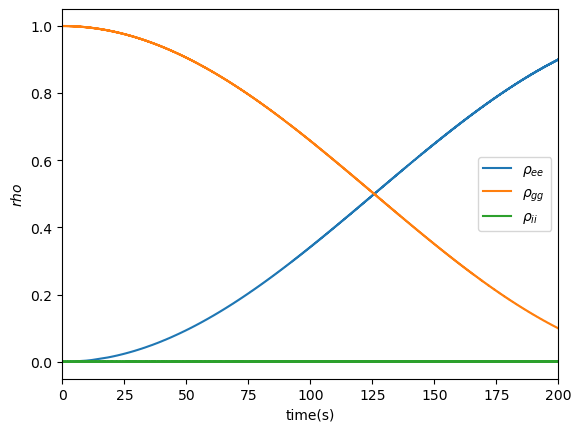

In [14]:
from matplotlib.axis import Axis
# Plot the results
fig, ax = plt.subplots()

ax.set_xlim(0,200)
ax.plot(t,rho_ee,label=r'$\rho_{ee}$ ')
ax.plot(t,rho_gg,label=r'$\rho_{gg}$ ')
ax.plot(t,rho_ii,label=r'$\rho_{ii}$')
#plt.plot(t,rho_ee1,'r--', label=r'$\rho_{ee}50$ ')
plt.xlabel('time(s)')
plt.ylabel('$rho$')
plt.ion()

plt.legend()
plt.show()